# Table of Contents
- [Introduction](#introduction)
- [Dataset Description and Preprocessing](#dataset)
- [Clustering with K-Means](#dataset)
- [Classification with Naive-Bayes](#classification)
<br/>

# 1 Introduction <a name="introduction"></a>

In this assignment, we demonstrate the usage of machine learning for clustering and classification of text data.

In the first part we make use of the K-means algorithm in order to cluster user reviews on certain Amazon products.
This process is useful when the reviews are unlabeled and we wish to create different categories automatically based on the content of the reviews.
The TFIDF algorithm is used to convert the text data into feature vectors used by the algorithm. The experiments show that the clustering algorithm was able to discover the most fundamental categories.

The second part assumes that the reviews are labeled. The requirement is to automate the classification process, in order to assign new reviews to their corresponding category.
For this purpose we train an Naive-Bayes classifier and examine the performance on the test dataset.
We cover aspects such as the performance metrics (accuracy, precision, recall, etc.), training dataset size tuning and running time of the algorithm, and
conclude that the algorithm is able to produce decent results.

The code used in this notebook can also run as a microservice with an integrated UI, so that the users can experiment and use it as an actual tool.
More on this on the readme.md file.

<br/>

# 2 Dataset Description and Preprocessing <a name="dataset"><a/>

## 2.1 The dataset
The dataset is composed of various user reviews on products of the following categories:

* Books
* Clothing, shoes and jewelry
* Movies and TV
* Musical Instruments
* Software

Some samples taken from the movies dataset:

In [37]:
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

from util import import_data
import_data('datasets/movies_5000.json', size=100, file_type='json', field='reviewText').sample(4)

input
21                                            I found this dvd put together with historical facts and visuals that kept my interest in the issues discussed. would recommend 6-12 grade classes watching this.
1   Believe me when I tell you that you will receive a blessing watching this video of the Cathedral Quartet.  They bring back most of the singers that were ever in their group and it is a really great VHS.
68                                                                                                                                                      A great contemporary perspective of A Christmas Carol!
10                                                                                                                             Watch this and learn how we ended up in the state we are in as a dying country.

The full dataset can be found here: http://jmcauley.ucsd.edu/data/amazon/

For our experiments we have sampled 5000 items from each category and created the corresponding json data file (for example, music_5000.json).
We also mixed samples from different categories in the files
samples_500_per_class.csv and samples_200_per_class.csv

In [30]:
%load_ext autoreload
%autoreload 2

from util import import_data
import random

random.seed(2)

size_per_class = 1000
data = import_data('datasets/clothing_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index()
data = data.append(import_data('datasets/books_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.append(import_data('datasets/movies_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.append(import_data('datasets/software_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.append(import_data('datasets/music_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.reset_index()
print("loaded data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loaded data


<br/>


## 2.2 Feature extraction
In order to represent the data in numeric form and in a meaningful way, the TFIDF algorithm is used.


### 2.2.1 Term Frequency – Inverse Document Frequency (TFIDF)
The TFIDF algorithm is used to transform a document into a numeric vector. Each unique word that appears in the
collection of documents (corpus), corresponds to a dimension of the vector. The algorithm combines two quantities:

<br/>

**Term Frequency**

The number of times a word $i$ appears in the document $d$ divided by the total number of words in that document.

<br/>

$TF(i,d) = \frac{f_{i,d}}{\sum_{i'\epsilon d} {f_{i',d}}}$


<br/>

**Inverse Document Frequency**

Common words that appear in most documents, may not provide useful information. In our use case, the words “good”,
“great” and “like” appear frequently in all kinds of user reviews, therefore do not add any value to the clustering process.
 Therefore the IDF score of a term is calculated, based on the number of documents containing this term versus the total
 number of documents:

 <br/>

$IDF(i,d) = \log\frac{|D|}{|\left \{ d\epsilon D: i\epsilon d \right \}|}$

<br/>

,where $|D|$ is the total count of documents, and $|\left \{ d\epsilon D: i\epsilon d \right \}|$ the count of documents containing the term i.
The TFIDF score is calculated by multiplying the above quantities:

<br/>

$ TFIDF(i,d) = TF(i,d) \cdot IDF(i,d)$

<br/>

**Example**

Consider the following documents:

* d0: “Good quality hat.“
* d1: “Fits great, looks good! “
* d2: “Good hat.“

The TDIDF matrix is calculated as:

In [14]:
import pandas as pd
from util.preprocess import TextPreprocessor

example = pd.Series(['Good quality hat.', 'Fits great, looks good!', 'Good hat.'])
tfidf_vector, tfidf_matrix, dense_tfidf_matrix = TextPreprocessor().generate_tfidf(example)
dense_tfidf_matrix

fit      good     great       hat      look   quality
0  0.000000  0.425441  0.000000  0.547832  0.000000  0.720333
1  0.546454  0.322745  0.546454  0.000000  0.546454  0.000000
2  0.000000  0.613356  0.000000  0.789807  0.000000  0.000000

### 2.2.2 Puncutation and stop words removal
In order to reduce the dataset size and noise, we remove punctuations and common words like “this”, “and”, “a”, etc…

Spacy.io is a fully featured library which can be used to perform such tasks.

### 2.2.3 Stemming/Lemmatization
Words inside a document need to be transformed to their root form in order for the TFIDF to perform. For example the words “driving” and “driver “ should point to the same term “drive”. Stemming is the process of performing such conversion.

Lemmatization is similar to stemming, while also taking into account meaning and the context in which the term is used. For example the words “people” and “person”, should point to the same lemma.

<br/>

## 2.3 Implementation

For preprocessing of the data we created a wrapper class that uses scikit-learn and spacy.
The class provides a method that takes the raw text data as input, performs lemmatization and stop words removal
and outputs the tfidf transformation.

In [16]:
from util.preprocess import TextPreprocessor



# 3 Clustering with Kmeans <a name="clustering"></a>

In this chapter we describe the Kmeans algorithm that was used for clustering the documents and discuss the results.

## 3.1. The Kmeans algorithm
Kmeans is an unsupervised machine learning algorithm for clustering data into a predefined number (K) of distinct groups (clusters). Each data point can belong only to a single cluster. The data is clustered in such a way that the sum of squared distances between a cluster’s centroid and all the points belonging to the cluster is minimized. 
The I/O of the algorithm is listed below:

Input: 
* Number of clusters
* Dataset

Output:
* Cluster centroids
* Clustered data points

The algorithm runs through an iterative process until a stop condition has occurred:

<br/>

<img src="kmeans.png" alt="kmeans" width="600"/>

## 3.2. Choosing optimal parameters

We will be using the silhouette method to determine the optimal number of clusters. The silhouette score is an indicator of how
well seperated the clusters are, and is defined by the following metric:

For each data point $i$, the mean distance from all points that belong to the same cluster $C_i$ is:

$a(i) = \frac{1}{|C_i|-1} \sum_{j \in C_i, j \neq i}{d(i,j)}$

We also define the mean distance of i from the all points that belong to the nearest cluster:

$b(i) = \min_{J \neq I}{\frac{1}{|C_J|}\sum_{j \in C_J}{d(i,j)}}$

The silhouette of point $i$ is defined as:

$s(i) = \frac{b(i)-a(i)}{\max\{a(i), b(i)\}}$

In [35]:
from services import *

size_per_class = 800
data = import_data('datasets/clothing_5000.json', size=5000, file_type='json',
                   field='reviewText').sample(size_per_class).reset_index()
data = data.append(import_data('datasets/books_5000.json', size=5000, file_type='json', field='reviewText').sample(
    size_per_class).reset_index())
data = data.append(
    import_data('datasets/movies_5000.json', size=5000, file_type='json', field='reviewText').sample(
        size_per_class).reset_index())
data = data.append(import_data('datasets/software_5000.json', size=5000, file_type='json', field='reviewText').sample(
    size_per_class).reset_index())
data = data.append(
    import_data('datasets/music_5000.json', size=5000, file_type='json', field='reviewText').sample(
        size_per_class).reset_index())
data = data.reset_index()
print("Loaded data")

tpr = TextPreprocessor(drop_common_words=False)
tfidf_vector, tfidf_matrix, dense_tfidf_matrix = tpr.generate_tfidf(data.input, debug=True)

Loaded data
Created tfidf transformer
Created tfidf matrix
Created tfidf dense matrix


In [41]:
%load_ext autoreload
%autoreload 2
from models.clustering import TextClustering
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

tcl = TextClustering(data, tfidf_matrix, tfidf_vector, 12)
tcl.find_optimal_clusters(20, debug=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


(Figure({
     'data': [{'hovertemplate': 'Number of clusters=%{x}<br>Score=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'symbol': 'circle'},
               'mode': 'markers',
               'name': '',
               'orientation': 'v',
               'showlegend': False,
               'type': 'scatter',
               'x': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                           20], dtype=int64),
               'xaxis': 'x',
               'y': array([0.00669626, 0.0100386 , 0.01103192, 0.01298847, 0.01465281, 0.01754388,
                           0.01962803, 0.02144197, 0.02253532, 0.02150416, 0.02130287, 0.02434694,
                           0.02223381, 0.02617998, 0.02433586, 0.0262203 , 0.02638911, 0.02636731,
                           0.02860733]),
               'yaxis': 'y'}],
     'layout': {'height': 400,
                'legend': {'tracegroupgap': 0},
             

Around the number 12 we can see that the curve slightly flattens.
Further increasing the number of clusters will not provide any benefit, since the clusters will become sparse and small in size.
Since the number of dimensions generated with TFIDF is very high compared to the number of samples,
the knee point of the curve is not so obvious.

## 3.3 Exploring and evaluating the clustered data

In [54]:
from IPython.display import display
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

n_clusters = 12
tcl.fit_kmeans(n_clusters)

for i in range(n_clusters):
    idx = tcl.clustered_data.pred == i
    print("Cluster {}".format(i))
    display(tcl.clustered_data.loc[idx, ['input', 'top_terms']][0:5])

c:\users\pmitseas\documents\mscai\machinelearning\assignment\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Cluster 0


input  \
211                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             As with her other 2 books, this one is a hit. Easy to follow patterns with fun & quick results! A fun book to have. I wish I would have bought it sooner!   
223                                                                                                                                                                                                                                                                                                                                   I'm not certain how I feel about this book or the writer. I've always felt a good book tells a story but a Great book uses dialogue to Show you a story. There was a Notable lack of dialogue in this book. However, the tale kept me turning the pages. I don't really understand it as neither of the main characters were all that likable. It had something.....not realism that made sense but something. I'm still debating whether to read this author's next book in the Barrington series.   
377  One White Lie by Jeannette Winters\n\nBrice Henderson wanted nothing but success for his company! He gave up everything and lets no one get in his way.\n\nLena Razzi has spent years trying to get over Brice and forget the pain he caused when he suddenly broke her heart. Once again she has found herself in his world and is at risk for another broken heart, especially when he finds out the secret she has kept from him.\n\nLoved this story. This is my first read by Jeannette Winters and I loved it. The story is strong, well written and one of those cant put it down until the end kind of books. This is the first in a series, which also connects with Ruth Cardello, and Danelle Stewarts series, although each of these books can be read alone. I am looking forward to reading more books in this series.   
451                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Excellent   
605                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Cluster 1


input  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Inexpensive, but very cheaply made plasticy jacket   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Good product. Like any pair of chucks the sole support is not very good but fashion is pain.   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                This looks great but the broom didn't hold up well at all.   
7  I've been wearing this style of Casio watches for a very long time, but my last one finally died. Since it's about the same cost to replace the battery as it is to get a new one, I got this. It is basically the same as my last one (one less button, but not a loss of functionality for what I need), so I got what I expected. It took a bit of getting used to the display of only the date (no month), but if you don't know what month it is, you probably have other issues. I also bought the LW201-1AV at the same time, and to be honest I like it a little better - maybe just because it's "new and different"? For either one, you can't beat the price!   
8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      okay   

                   top_terms  
2  [great\n, good\n, like\n]  
3  [great\n, good\n, like\n]  
4  [great\n, good\n, like\n]  
7  [great\n, good\n, like\n]  
8  [great\n, good\n, like\n]

Cluster 2


input  \
1310  Microserfs\n\nDouglas Coupland was born 12-30-1962 on a Canadian NATO base in West Germany, then grew up and lives in Vancouver Canada. He wrote other books. This novel is based on the lives of Microsoft workers who work long hours programming the software that makes personal computer hardware respond to customer commands. Using fiction means never having to use footnotes yet still present a picture of computer workers and their lives. This 1995 book has seven chapters on its 371 pages. It begins in the Fall of 1993 and ends in January 1995. It tells about other events in that era. It is like a Web Log that records daily activity but does not go into details about Daniels work. Does this story tell something about it author? Does this book have any value for most people? No, I would advise a good murder mystery.\n\nDaniels father suffers from a cutback at work. [Every expandingbusiness reaches a plateau then a reduction in force.] His younger brother Jed in a swimming accident years earlier. [No details about this although Dan was present.] The story tells about their work pressures and schedules, their choices in diet, etc. The expect to be burned out or retired by age fifty. Then they hope to live in luxury (as long as their stock in Microsoft pays off). You can read between the lines to understand their work environment. What if their jobs are outsourced to a foreign country? Do they have a viable Plan B? Would forming a trade union help?\n\nBy Chapter 2 it become weary - those pages with large type for random words. Daniel earned $26K a year; was that a fair wage for a sixty-hour week? He was a tester not a programmer. This is just as important even if a lower skill set. The designer is the most important, like the writer of the script for a movie. All depend on a financier to provide funding. They work on games, a non-productive use of resources that entertains and doesnt educate. Is America running out of telephone numbers (p. 79)? Was this due to poor design (the use of 0 or 1 for area codes? The importance of Lego is the correlation to an age level and a preference to constructing a whole from simple parts. Remember Lincoln Logs? Or is that like IBM Hollerith cards?\n\nThere is more padding (pp. 104-105). Daniel and his friends migrate to California for a new business opportunity (Chapter 3). The differences are noted. [This is before the current drought.] Are its referenced dated like slang from the 1940s? George Orwells novel 1984 warned against the thought control of Big Business. One example is the foolish talk about clothing stores in Chapter 5, they are oblivious to their brain-washing! Chapter 7 seems to be tacked on for its sensationalism. It ends with a sudden attack of sickness, then sentimental feelings. Will their product be a success? For what length of time? Eventually the users will drop it for another toy. What is more fickle than fashion, and those who profit from creating changing tastes?   
2400                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Cluster 3


input                   top_terms
20                  great  [great\n, price\n, work\n]
28     Color is Great....  [great\n, price\n, work\n]
50              Great! !!  [great\n, price\n, work\n]
54                  great  [great\n, price\n, work\n]
94  Everything was great.  [great\n, price\n, work\n]

Cluster 4


input  \
0                                              Love them   
6                                    LOVE THESE SNEAKERS   
12  A gift for my granddaughter, she seems to love them.   
22                                             loved it!   
35                                             Love 'em.   

                       top_terms  
0   [love\n, daughter\n, book\n]  
6   [love\n, daughter\n, book\n]  
12  [love\n, daughter\n, book\n]  
22  [love\n, daughter\n, book\n]  
35  [love\n, daughter\n, book\n]

Cluster 5


input  \
75                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Lovely color and will work for pregnancy and nursing.   
209  Beautiful watch.  Gave to my wife as a Christmas present, and she loves it.  Band adjusts easily (she has slim wrists, and I was concerned whether it would adjust to that small a wrist size)and overall it shows nicely on her wrist.  Kind of watch she wears to work then wears out to dinner.  Has a second hand, which is important to her for work.  Time seems extremely accurate;  packaging was very nice (neat little box) and directions provided were very good.\n\nOverall, very satisfied!\n\nUPDATED 5/18/2015\nAlmost three and a half years later watch is still working perfectly, with the original battery still powering it.  Very good watch!   
391                                                                                                                                                                                                                                                                                                                                                                                                                                                 I have been looking for something over than the plastic watchband.  This works perfectly.  I actually wear my Suunto watch more often now.  After several weeks of heavy work, the band still looks, and smells, new.   
574                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    I love this - I bought 2.  It works well on cold New England days.   
683                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          It's a cute top, works good for nursing and lazy don't care how I look days.   

                     top_terms  
75   [work\n, great\n, fine\n]  
209  [work\n, great\n, fine\n]  
391  [work\n, great\n, fine\n]  
574  [work\n, great\n, fine\n]  
683  [work\n, great\n, fine\n]

Cluster 6


input  \
5                                             good   
18                                            Good   
160                                           good   
186                                   Good product   
220  Well made for them price.\nLooked very good ,   

                          top_terms  
5    [good\n, product\n, quality\n]  
18   [good\n, product\n, quality\n]  
160  [good\n, product\n, quality\n]  
186  [good\n, product\n, quality\n]  
220  [good\n, product\n, quality\n]

Cluster 7


input  \
968                                                                                                                                                                                 Great buy!! My baby loves them and is so happy cuz he got movies lol!   
1008                                                                                                                                                                                                         Start here before you move on to the movies.   
1273  Was enjoyable and most interesting movie but difficult to understand a lot of the conversations due to the strong  English dialect; however, after movie was viewed, my wife found we could have input English/American translations on the screen.   
1297                                                                                                                                                  I have seen the movie many times and now know how much literally license the movie-makers can take!   
1606                                                                                                                                                                                                               One of my fav movies! Phenomenal cast!   

                      top_terms  
968   [movie\n, good\n, love\n]  
1008  [movie\n, good\n, love\n]  
1273  [movie\n, good\n, love\n]  
1297  [movie\n, good\n, love\n]  
1606  [movie\n, good\n, love\n]

Cluster 8


input  \
9                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              great shoe   
13  Look and feel great. Except they are definitely not genuine Converse brand because they started to fall apart after about a dozen or so wears. Mostly on the right shoe only. As you'll see in pictures, it's come apart near the top left outside and inside of the shoe. Really a bummer because I had planned on using the same buyer to get more colors. Alas, lesson learned. I wouldn't recommend buying from this seller because they're not guaranteed genuine long-lasting quality Converse.   
14                                                                                                                                                                                                                                                                                                                                                                                   Love these shoes.  I have to make an effort not to wear them every day.  They are very comfortable and very cute on.   
15                                                                                                                                                                                                                                                                                                                                                               They are Chucks...what can I say.  Love this shoe.  You already know to order them a half size smaller...so go ahead and pick up a pair!   
19                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         GREAT SHOES!!!   

                    top_terms  
9   [shoe\n, size\n, great\n]  
13  [shoe\n, size\n, great\n]  
14  [shoe\n, size\n, great\n]  
15  [shoe\n, size\n, great\n]  
19  [shoe\n, size\n, great\n]

Cluster 9


input  \
1                                                                                                                                            It fit pretty good   
25                                                                                                                                         Fits awesome love it   
33                                                                                                         Fit way too big please read reviews before buying...   
52                                                                                                              The fit is right arrived on time very satisfied   
55  For the price, this costume was great and the large fit my 6 ft 190# husband just right. We thought about adding some straw but it looked great without it.   

                     top_terms  
1   [fit\n, expect\n, great\n]  
25  [fit\n, expect\n, great\n]  
33  [fit\n, expect\n, great\n]  
52  [fit\n, expect\n, great\n]  
55  [fit\n, expect\n, great\n]

Cluster 10


input  \
67                        What can I say? They're classic chucks, nuff said   
208                                       Classic Chucks. Very comfortable.   
324  Love the classics. These are exactly what I expected at a great price.   
461                                Classic. The same chucks I know and love   
647                                                                 classic   

                        top_terms  
67   [classic\n, love\n, great\n]  
208  [classic\n, love\n, great\n]  
324  [classic\n, love\n, great\n]  
461  [classic\n, love\n, great\n]  
647  [classic\n, love\n, great\n]

Cluster 11


input  \
89                                   Granddaughter loves them even so white! Fit is perfect!   
118                                                              Perfect. Just as described.   
207                                                These worked perfect for my son's costume   
221  First pair of Converse.  I have a wide foot and these are perfect for me!  I love them!   
233                                                            They are perfect. Thanks !!!!   

                         top_terms  
89   [perfect\n, fit\n, costume\n]  
118  [perfect\n, fit\n, costume\n]  
207  [perfect\n, fit\n, costume\n]  
221  [perfect\n, fit\n, costume\n]  
233  [perfect\n, fit\n, costume\n]

We can see that the cluster with most points, contains data that are too generic
and do not contain any specific meaning. For example:

*these rock!*

*Perfect Is the word....*

*Lasted less than 6 months under normal wear.*

By examining the other clusters we can distinguish the different types of products (books, movies, shoes, computer programs and instruments).
The silhouette plot for the clusters, which confirm the above:

c:\users\pmitseas\documents\mscai\machinelearning\assignment\venv\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



For n_clusters = 12 The average silhouette_score is : 0.019932683485010896


c:\users\pmitseas\documents\mscai\machinelearning\assignment\venv\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



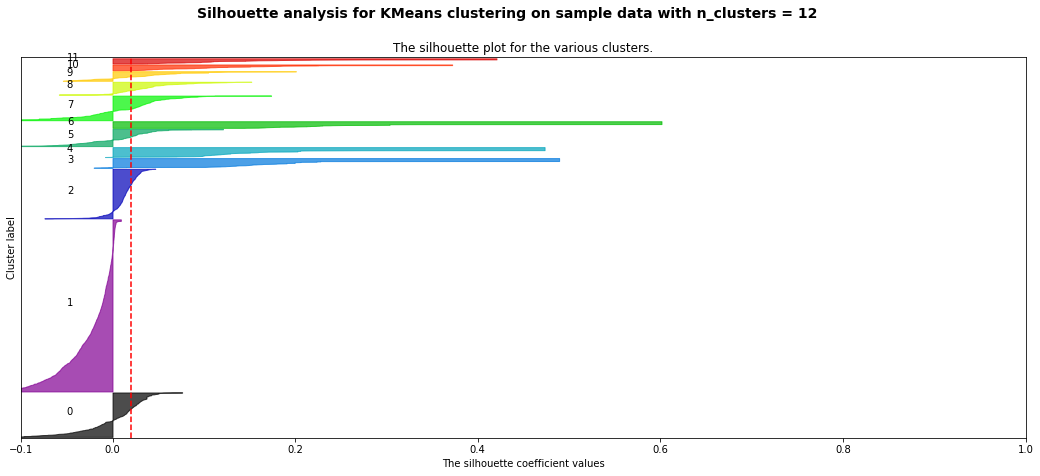

<module 'matplotlib.pyplot' from 'c:\\users\\pmitseas\\documents\\mscai\\machinelearning\\assignment\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [58]:
tcl.plot_silhouette()

Another way of visualizing the clusters is to plot the points and colorize according to their cluster.
Because the number of dimensions of the TFIDF matrix is extremely high, we can perform a PCA transform of the matrix and
keep a small number of coordinates. These coordinates carry only a small percentage of the total information, but enough
to illustrate a point.

In [57]:
import plotly.express as px
from sklearn.decomposition import TruncatedSVD
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

svd = TruncatedSVD(n_components=5)
Y = svd.fit_transform(tcl.tfidf_matrix)
print(svd.explained_variance_ratio_)
fig = px.scatter_matrix(Y, color=tcl.clustered_data.pred)
fig.show()

fig2 = px.scatter(x=Y[:,0], y=Y[:,3], color=tcl.clustered_data.pred)
fig2.show()
fig3 = px.scatter(x=Y[:,2], y=Y[:,4], color=tcl.clustered_data.pred)
fig3.show()
fig4 = px.scatter(x=Y[:,4], y=Y[:,3], color=tcl.clustered_data.pred)
fig4.show()

[0.01022853 0.01846749 0.01689507 0.01142114 0.01142779]


As we can see, the cluster with the most points cannot be safely distinguished from others
since it carries the most generic information (reviews). This is also visible in the silhouette plot.

In [45]:
%load_ext autoreload
%autoreload 2

from util import import_data

def generate_dataset(size):
    data = import_data('datasets/clothing_5000.json', size=5000, file_type='json',
                       field='reviewText', label='clothing').sample(size).reset_index()
    data = data.append(import_data('datasets/books_5000.json', size=5000, file_type='json',
                                   field='reviewText', label='books').sample(
        size).reset_index())
    data = data.append(
        import_data('datasets/movies_5000.json', size=5000, file_type='json', field='reviewText',
                    label='movies').sample(
            size).reset_index())
    data = data.append(import_data('datasets/software_5000.json', size=5000, file_type='json', field='reviewText',
                                   label='software').sample(
        size).reset_index())
    data = data.append(
        import_data('datasets/music_5000.json', size=5000, file_type='json', field='reviewText',
                    label='music').sample(
            size).reset_index())
    data = data.reset_index()
    return data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 4 Classification with Naive Bayes <a name="classification"></a>

The purpose of this process is to train a classifier model, to assign user reviews to the output categories.
This would be useful for automated categorization of reviews, or identifying user preferences.
For text classification we consider using Naive Bayes or SVM as the classifiers.

## 4.1 Naive Bayes

Naive Bayes is based on the assumption that the features (dimensions) present in the input data, are independent of one another.
Given an input variable $f_i$, an observation $F$ and a class label $c_k$. The algorithm uses the Bayes therorem to calculate the probability:

$P(c_k|f_i=F) =  \frac{P(f_i=F|c_k)P(c_k)}{P(f_i=F)} = \frac{P(f_i=F|c_k)P(c_k)}{\sum_j{P(f_i=F|c_j)}P(c_j)} $

The variable $f_i$ can be discrete or continuous. In the latter case, during the training phase, the algorithm estimates the parameters of the probability density function:

$p(f_i|c_j)$

, for each class $c_j$ and assuming a gaussian or multinomial distribution. In the case of NLP the multinomial naive Bayes gives better results,
due to the bag of words model used for feature extraction. These features are better approximated by multinomial rather than gaussian distributions.


## 4.2 Initial attempt with 200 samples per class
We present the result of the Naive Bayes algorithm for a small number of samples. The metrics presented
are:

* Accuracy
* Precision
* Recall
* F1 score
* Confusion matrix

Accuracy is a generic measure that shows the total correct predictions versus the total predictions.
The rest of the metrics are calculated per class. Precision is an insight of how sensitive is the algorithm to misclassifying samples to the specific class, that
should belong to other classes. On the other hand, Recall shows the ability of the classifier to identify the samples that truly belong to the specific class.
F1 is a combination of the above


In [49]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import plotly.express as px
import pandas as pd
from IPython.display import display
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

from models.classification import TextClassification
from sklearn.model_selection import train_test_split

data = generate_dataset(200)
X_train, X_test, y_train, y_test = train_test_split(data.input, data.label, test_size=0.2)
tcf = TextClassification()
tcf.train(X_train, y_train)

labels = ["books", "movies", "software", "clothing", "music"]

y_pred, pred_time = tcf.predict(X_test)
acc = tcf.accuracy_score(X_test, y_test)
pre, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, labels=labels)
metrics_exp_0 = pd.DataFrame({'Accuracy': [acc] * 5,
                        'Precision': pre,
                        'Recall': rec,
                        'F1': f1,
                        'Label': labels})
display(metrics_exp_0)

cm = confusion_matrix(y_test, y_pred, labels=["books", "movies", "software", "clothing", "music"])
df_cm = pd.DataFrame(cm, columns=["books", "movies", "software", "clothing", "music"], index=labels)
fig = px.imshow(df_cm, title="Confusion matrix for dataset with 200 samples per class (80/20 split).",
                labels={'x': 'predicted (y_pred)', 'y': 'actual (y_test)'})
fig.show()

Accuracy  Precision    Recall        F1     Label
0     0.855   0.926829  0.904762  0.915663     books
1     0.855   0.870968  0.818182  0.843750    movies
2     0.855   0.837209  0.923077  0.878049  software
3     0.855   0.794872  0.861111  0.826667  clothing
4     0.855   0.847826  0.780000  0.812500     music

Investigating the cases where the prediction doesn't match the real label, we can see that the input text in those cases is very generic, like
*Love it!*, *Item as described*

In [50]:
df_pred = pd.DataFrame({'pred': y_pred, 'actual': y_test}).join(data)
df_pred.loc[df_pred.pred != df_pred.label, ['pred', 'actual', 'input']]

pred    actual  \
431  clothing    movies   
255    movies     books   
168     music  clothing   
533     music    movies   
711     music  software   
361    movies     books   
169     music  clothing   
807  software     music   
791     music  software   
835  software     music   
262    movies     books   
721     music  software   
120     music  clothing   
860  clothing     music   
471     books    movies   
998  software     music   
498  clothing    movies   
303  software     books   
146  software  clothing   
978  software     music   
850  software     music   
473  clothing    movies   
509  clothing    movies   
99      books  clothing   
877  clothing     music   
907    movies     music   
855  clothing     music   
801  clothing     music   
925     books     music   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             input  
431                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Received as expected in great condition.  
255                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           100%  
168                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## 4.3 Visualization of the classified points
In order to visualize the points, first we have to perform a dimensionality reduction using PCA.
We keep the 5 most important transformed dimensions and plot pairwise.

The colors of the points match their respective category only of the predicted label is equal to the true label.
If the point is misclassified it is denoted in red.

In [51]:
from util import TextPreprocessor
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

svd = TruncatedSVD(n_components=5)
vb = tcf.tpr.vocabulary
tpr = TextPreprocessor(vocabulary=vb)

data = generate_dataset(1000)
X_prod, y_prod = data.input, data.label
y_pred_, pred_time = tcf.predict(X_prod)
print("Finished in {}", pred_time)
print("generating pca trasform and plot")

tfidf_vector, tfidf_matrix, _ = tpr.generate_tfidf(X_prod, debug=False, dense=False)
Y = svd.fit_transform(tfidf_matrix)
fig = px.scatter(x=Y[:,1], y=Y[:,3], color=[v if v == u else 'incorrect class' for v, u in zip(y_prod, y_pred_)])
fig.show()
fig3 = px.scatter(x=Y[:,2], y=Y[:,4], color=[v if v == u else 'incorrect class' for v, u in zip(y_prod, y_pred_)])
fig3.show()
fig4 = px.scatter(x=Y[:,4], y=Y[:,3], color=[v if v == u else 'incorrect class' for v, u in zip(y_prod, y_pred_)])
fig4.show()

Finished in {} 75.88492059707642
generating pca trasform and plot


## 4.4 Adjusting the sample size
We can increase the dataset used for training and examine how the different scores, as well as the training time, are affected.
For the precision, recall and F1 we will be taking the average of all classes.

In [11]:
import numpy as np

print("Running experiment with multiple training sample sizes. May take a while")
sample_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
acc, pre, rec, f1, sup = [], [], [], [], []
training_time = []
testing_time = []
feature_size = []

for size in sample_sizes:
    # Generate and split
    data = generate_dataset(size)
    X_train, X_test, y_train, y_test = train_test_split(data.input, data.label, test_size=0.2)

    # Train model
    tcf = TextClassification()
    feature_size_, training_time_ = tcf.train(X_train, y_train)

    # Calculate scores
    y_pred, testing_time_ = tcf.predict(X_test)
    pre_, rec_, f1_, sup_ = precision_recall_fscore_support(y_test, y_pred, labels=labels, average='weighted')

    acc.append(tcf.accuracy_score(X_test, y_test))
    pre.append(pre_)
    rec.append(rec_)
    f1.append(f1_)
    sup.append(sup_)
    feature_size.append(feature_size_)
    training_time.append(training_time_)
    testing_time.append(testing_time_)

metrics_exp_1 = pd.DataFrame({
    'samples per class': sample_sizes,
    'training_time': training_time,
    'testing_time': testing_time,
    'testing_time_per_sample': np.array(testing_time) / np.array(sample_sizes),
    'feature_size': feature_size,
    'accuracy': acc,
    'precision': pre,
    'recall': rec,
    'F1': f1})
print("Done")

Done


In [52]:
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
display(metrics_exp_1)

df_metrics = metrics_exp_1.melt(
    id_vars=['samples per class', 'training_time', 'testing_time', 'feature_size', 'testing_time_per_sample'],
    var_name='metric', value_name='score')

import plotly.express as px

fig = px.line(df_metrics, x='samples per class', y='score', color='metric', title='Performance metrics')
fig.show()

df_time = metrics_exp_1.loc[:, ['feature_size', 'training_time', 'testing_time_per_sample']].melt(id_vars=['feature_size'], var_name='metric', value_name='score')
fig2 = px.line(df_time, x='feature_size', y='score', color='metric', title='Training and Testing time')
fig2.show()

fig3 = px.histogram(df_metrics, x='testing_time_per_sample', title='Distribution of the testing times per sample')
fig3.show()


samples per class  training_time  testing_time  testing_time_per_sample  \
0                  50       4.029004      1.005032                 0.020101   
1                 100       7.857004      2.348038                 0.023480   
2                 200      14.322013      4.138989                 0.020695   
3                 300      22.532997      7.393111                 0.024644   
4                 400      29.310971      7.782029                 0.019455   
5                 500      40.801944     10.305041                 0.020610   
6                 600      50.183286     11.846969                 0.019745   
7                 700      55.791870     12.986999                 0.018553   
8                 800      58.013751     16.886000                 0.021107   
9                 900      64.274037     17.437995                 0.019376   
10               1000      75.035968     19.387996                 0.019388   

    feature_size  accuracy  precision    recall        F1  
0           2739  0.600000   0.702996  0.600000  0.611830  
1           4365  0.830000   0.847989  0.830000  0.833256  
2           6011  0.835000   0.841643  0.835000  0.835074  
3           7671  0.826667   0.832063  0.826667  0.827257  
4           8399  0.855000   0.864227  0.855000  0.854536  
5           9503  0.870000   0.872489  0.870000  0.869498  
6          10549  0.868333   0.873092  0.868333  0.867201  
7          11350  0.870000   0.872379  0.870000  0.870156  
8          11878  0.863750   0.865749  0.863750  0.863894  
9          12645  0.855556   0.860786  0.855556  0.854814  
10         13648  0.877000   0.880084  0.877000  0.877041

It is obvious that further increasing the training dataset's size past a specific point (around 200 samples per class), doesn't
increase the classifier's performance any further.

The training time complexity of naive bayes is O(n), while for TFIDF an efficient implementation performs the transformation in O(nlogn).
Therefore the total complexity is O(n) + O(nlogn), which can be verified from the diagram above.

The training time per sample remains relatively the same.

## 4.5 Shuffle & Split validation
We measure the algorithm's robustness by repeating the train-test process multiple times.
At each iteration the dataset's samples are shuffled and then split to train/test datasets, keeping the same ratio (0.2).

In [16]:
from sklearn.model_selection import ShuffleSplit

df = generate_dataset(200)
rs = ShuffleSplit(n_splits=40, train_size=200, test_size=100)

acc, pre, rec, f1, sup = [], [], [], [], []
for train_idx, test_idx in rs.split(df):
    df_train = df.loc[train_idx, :]
    df_test = df.loc[test_idx, :]

    X_train, X_test, y_train, y_test = df_train.input, df_test.input, df_train.label, df_test.label

    # Train model
    tcf = TextClassification()
    feature_size_, training_time_ = tcf.train(X_train, y_train)

    # Calculate scores
    y_pred, testing_time_ = tcf.predict(X_test)
    pre_, rec_, f1_, sup_ = precision_recall_fscore_support(y_test, y_pred, labels=labels, average='weighted')

    acc.append(tcf.accuracy_score(X_test, y_test))
    pre.append(pre_)
    rec.append(rec_)
    f1.append(f1_)
    sup.append(sup_)

metrics_exp_2 = pd.DataFrame({
    'accuracy': acc,
    'precision': pre,
    'recall': rec,
    'F1': f1})

print("Done")

Done


In [53]:
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

df_metrics_exp_2 = metrics_exp_2.melt(var_name="metric", value_name="score")
fig = px.histogram(df_metrics_exp_2, x='score', facet_col='metric', histnorm='probability density')
fig.show()

# 5 Conclusion

We have demonstrated the means to categorize and label text reviews using the most popular clustering and classification algorithms.
Please run the microservice included in the repo, which offers the above as a tool.